# Advanced Lane Finding

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob

%matplotlib inline

**Find Camera Calibration Matrix**

In [2]:
chessboard_cols, chessboard_rows = 9, 6

# prepare object points
objp = np.zeros((chessboard_cols*chessboard_rows,3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard_cols,0:chessboard_rows].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_cal/calibration*.jpg')

# Go through all the calibration images and find the chessboard corners 
for fname in images:
    img = mpimg.imread(fname)    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (chessboard_cols,chessboard_rows), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (chessboard_cols,chessboard_rows), corners, ret)
#         plt.figure()
#         plt.title(fname)
#         plt.imshow(img)

# using the data from all the calibration images, find the calibration matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

**Undistorted Checkerboard Image**

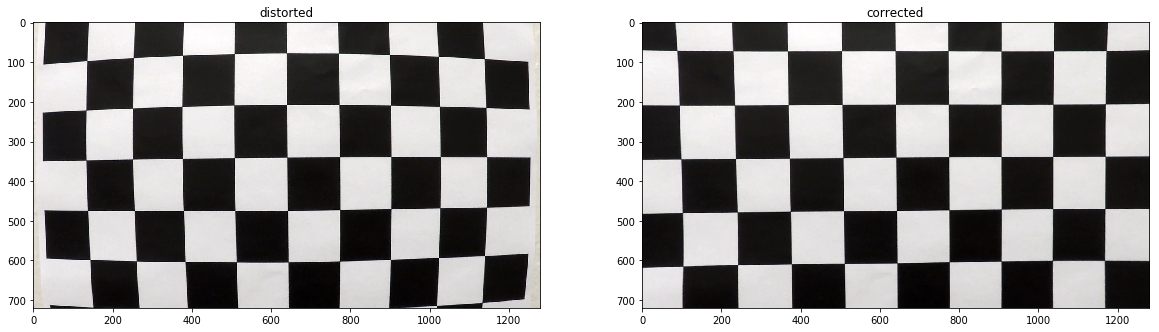

In [3]:
img = mpimg.imread('camera_cal/calibration1.jpg')  
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
ax1.set_title('distorted')
ax1.imshow(img)
ax2.set_title('corrected')
ax2.imshow(dst)
plt.savefig('output_images/undistorted_checkerboard.png')



**Example of an Undistorted Road Images**

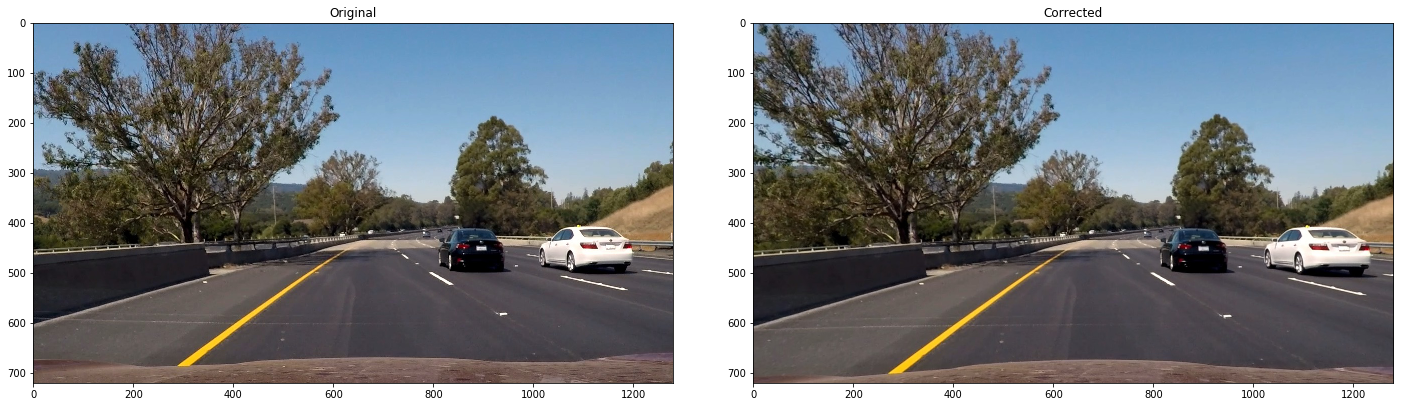

In [4]:
fname = 'test_images/test6.jpg'
img = mpimg.imread(fname)  
dst = cv2.undistort(img, mtx, dist, None, mtx)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
# fig.suptitle(fname)
ax1.set_title('Original')
ax1.imshow(img)
ax2.set_title('Corrected')
ax2.imshow(dst)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig('output_images/undistorted_test6.png', bbox_inches = 'tight', pad_inches = 0)

**Thresholded Binary Image**

In [5]:
def create_binary_image(img, s_thresh=(170, 255), sx_thresh=(20, 100), yellow_thresh=100, white_thresh=230):
    """
    This pipeline takes an image and returns in black/white binary.
    It is computed using the thresholds, the Sobel operator,
    and the L and S channels in the HLS colorspace.
    """
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # R and G color channels for detecting white/yellow lines  
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]

    # Threshold for yellow lines
    yellow_binary = np.zeros_like(s_channel)
    yellow_binary[(r_channel >= yellow_thresh) & (g_channel >= yellow_thresh)] = 1
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) | (sxbinary == 1)) & (yellow_binary==1)] = 1
#     combined_binary = s_binary
    combined_binary_3d = np.dstack(( combined_binary, combined_binary, combined_binary)) * 255

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return combined_binary_3d


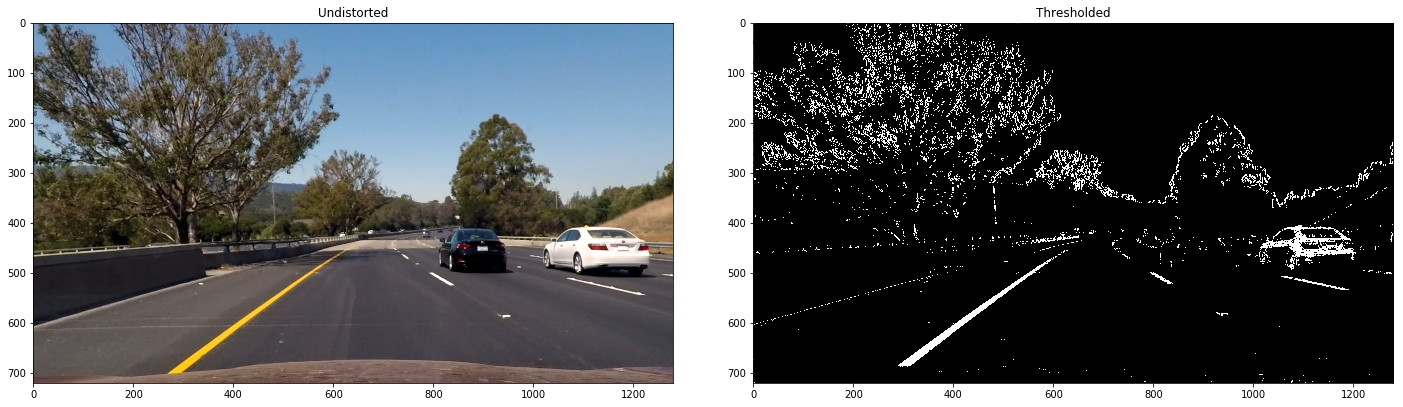

In [6]:
fname = 'test_images/test6.jpg'
img = mpimg.imread(fname)  
dst = cv2.undistort(img, mtx, dist, None, mtx)
binary_image = create_binary_image(img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
# fig.suptitle(fname)
ax1.set_title('Undistorted')
ax1.imshow(dst)
ax2.set_title('Thresholded')
ax2.imshow(binary_image)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.savefig('output_images/binary_test6.png', bbox_inches='tight', pad_inches=0)

**Perspective Tranform**

In [7]:
# Harcoded source and destination vertices for the perspective transform
src_vertices =  np.float32([(580, 460), (710, 460), (1115, 720), (210, 720)])
# src_vertices =  np.float32([(580, 450), (710, 450), (1115, 720), (210, 720)])
dst_vertices = np.float32([(300, 0), (1000, 0), (1000, 720), (300, 720)])

# Compute transform and inverse transform
M = cv2.getPerspectiveTransform(src_vertices, dst_vertices)
Minv = cv2.getPerspectiveTransform(dst_vertices, src_vertices)

def apply_perspective_transform(img):
    ysize, xsize, _ = img.shape
    return cv2.warpPerspective(img, M, (xsize,ysize), flags=cv2.INTER_LINEAR)

def apply_inverse_perspective_transform(img):
    ysize, xsize, _ = img.shape
    return cv2.warpPerspective(img, Minv, (xsize,ysize), flags=cv2.INTER_LINEAR)


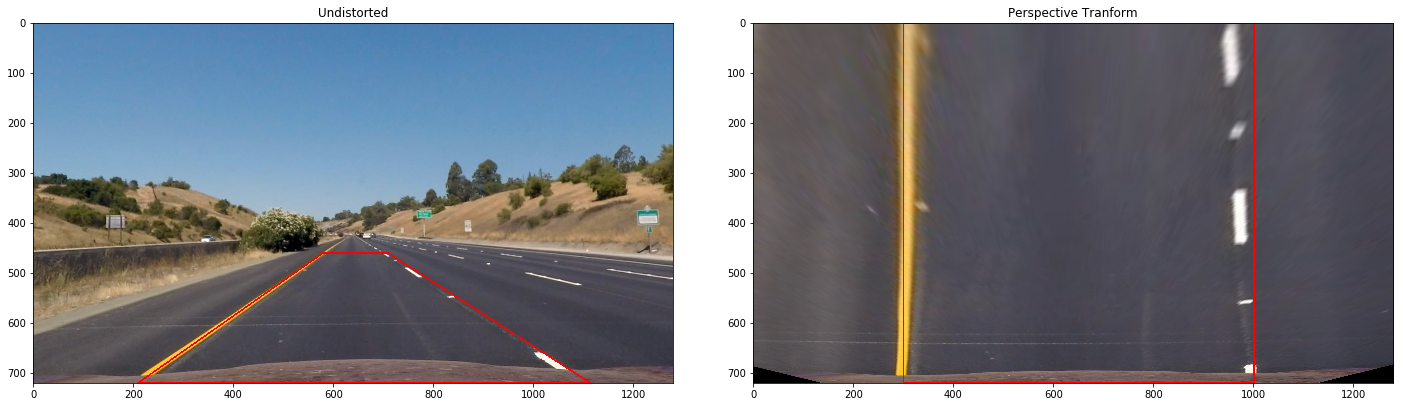

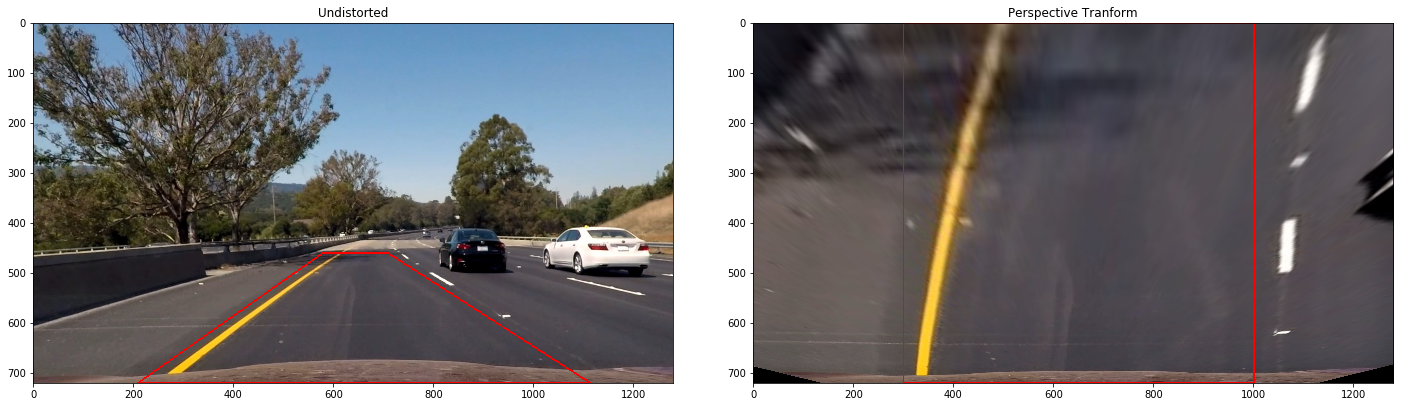

In [8]:
folder = 'test_images/'
fnames = ['straight_lines1.jpg', 'test6.jpg']

for fname in fnames:
    img = mpimg.imread(folder + fname)  
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    perspective_transform = apply_perspective_transform(img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

    # Draw source and destination points on original image and transform
    cv2.polylines(dst, [src_vertices.astype(np.int32)], True, thickness=2, color=(255,0,0))
    cv2.polylines(perspective_transform, [dst_vertices.astype(np.int32)], True, thickness=2, color=(255,0,0))

    ax1.set_title('Undistorted')
    ax1.imshow(dst)
    ax2.set_title('Perspective Tranform')
    ax2.imshow(perspective_transform)
#     plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
#     plt.margins(0,0)
#     plt.gca().xaxis.set_major_locator(plt.NullLocator())
#     plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('output_images/perspective_' + fname[:-4] + '.png', bbox_inches='tight', pad_inches=0)


**Identify Lane Pixels and Fit Polynomials**

In [9]:
def find_lane_pixels(binary_warped):
    #convert binary warped image from 3d to 2d
    binary_warped = binary_warped[:,:,0]
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100#120
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines        
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))], dtype=np.int32)
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))], dtype=np.int32)

    cv2.polylines(out_img, [left_line_pts], isClosed=False, color=(255,255,0), thickness=2)
    cv2.polylines(out_img, [right_line_pts], isClosed=False, color=(255,255,0), thickness=2)
    return out_img

    

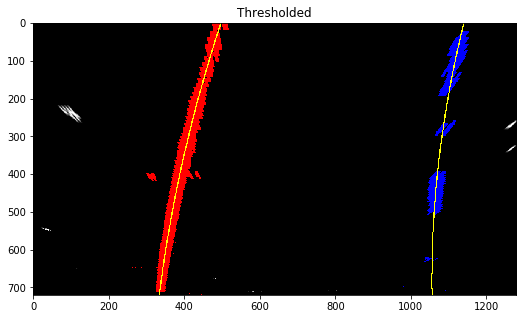

In [10]:
fname = 'test_images/test6.jpg'
img = mpimg.imread(fname)  
dst = cv2.undistort(img, mtx, dist, None, mtx)
binary_image = create_binary_image(dst)
binary_warped = apply_perspective_transform(binary_image)
out_img = fit_polynomial(binary_warped)

plt.figure(figsize=(20,5))
plt.title('Thresholded')
plt.imshow(out_img)

plt.savefig('output_images/fit_test6.png', bbox_inches='tight', pad_inches=0)

**Calculate Curvature and Vehicle Position**

In [11]:
def calculate_curvature(left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 720
    
    # calculate curvature of right curve
    A, B, C = left_fit
    A *= xm_per_pix/(ym_per_pix**2)
    B *= xm_per_pix/ym_per_pix
    left_curverad = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
    
    # calculate curvature of right curve
    A, B, C = right_fit
    A *= xm_per_pix/(ym_per_pix**2)
    B *= xm_per_pix/ym_per_pix
    right_curverad = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
    
    # return average of the two lane curvatures
    return left_curverad+right_curverad/2

    
def calculate_vehicle_position(left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    calculated_center = (left_fitx[-1] + right_fitx[-1])/2
    expected_center = 1280/2
    
    return (expected_center-calculated_center)*xm_per_pix

**Draw Lane Region on Non-warped Image**

In [12]:
def draw_lane_area(img_warped, binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, _ = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_warped.shape[0]-1, img_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img = np.zeros_like(img_warped)

    # Draw green lane region
    left_line_pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))], dtype=np.int32)
    right_line_pts = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))], dtype=np.int32)
    poly_pts = np.hstack((left_line_pts, right_line_pts))
    cv2.fillPoly(out_img, [poly_pts], color=(0,255,0))
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return left_fit, right_fit, left_fitx, right_fitx, out_img


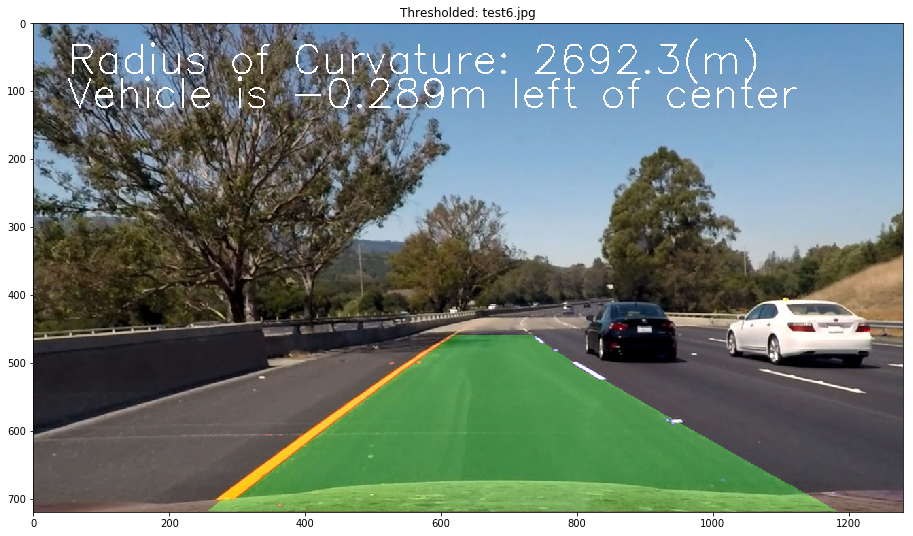

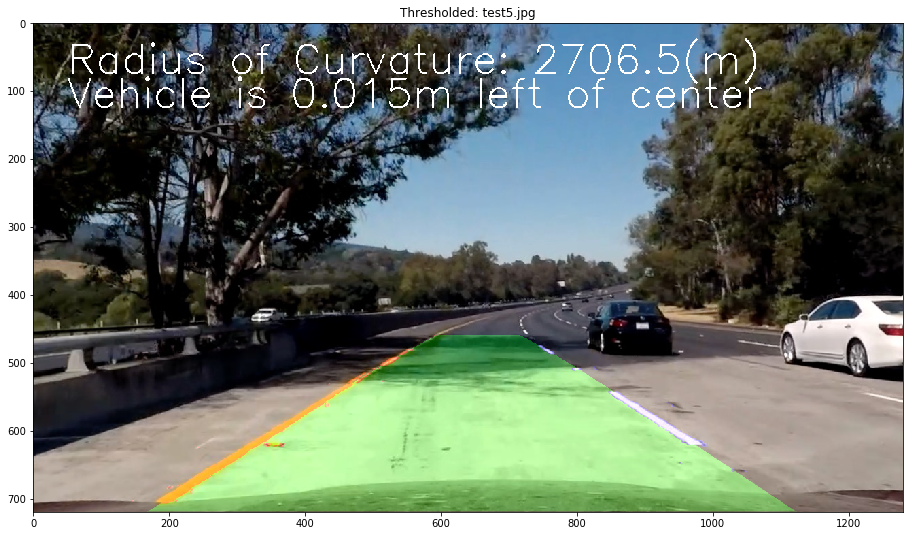

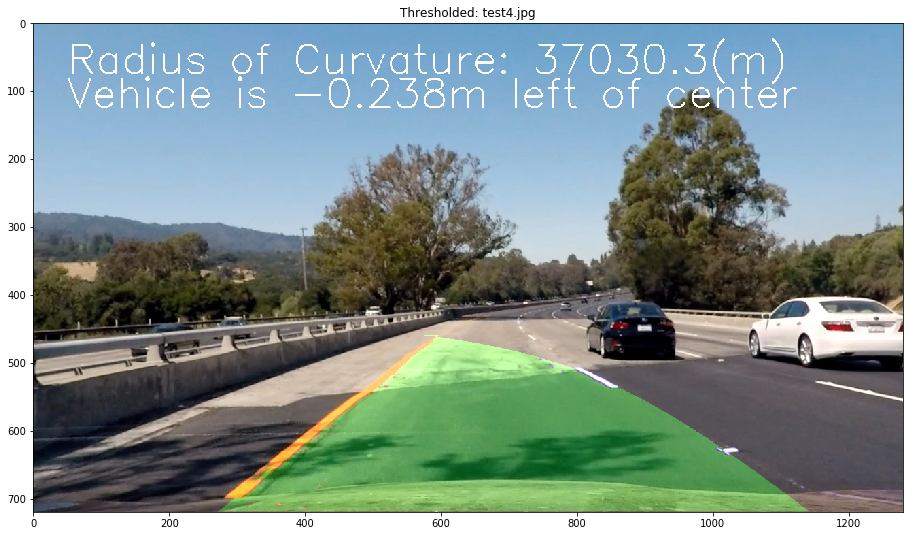

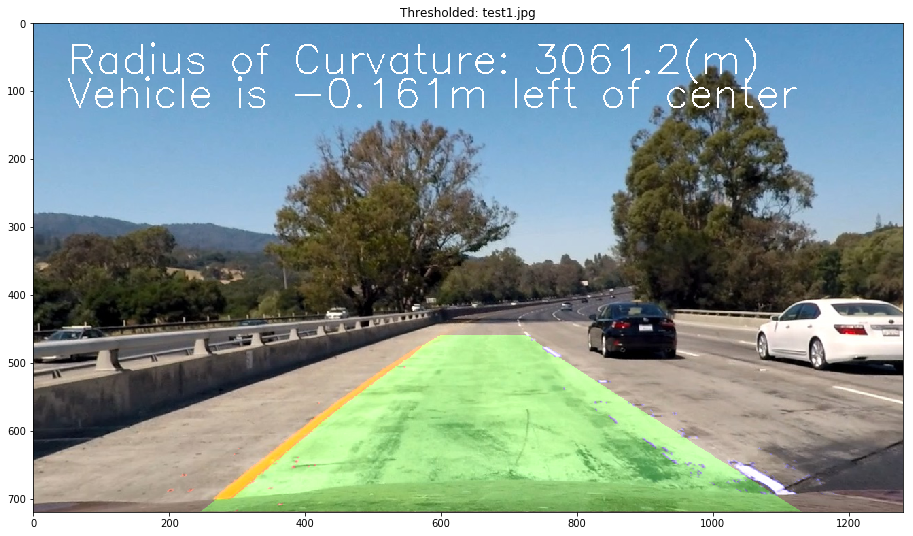

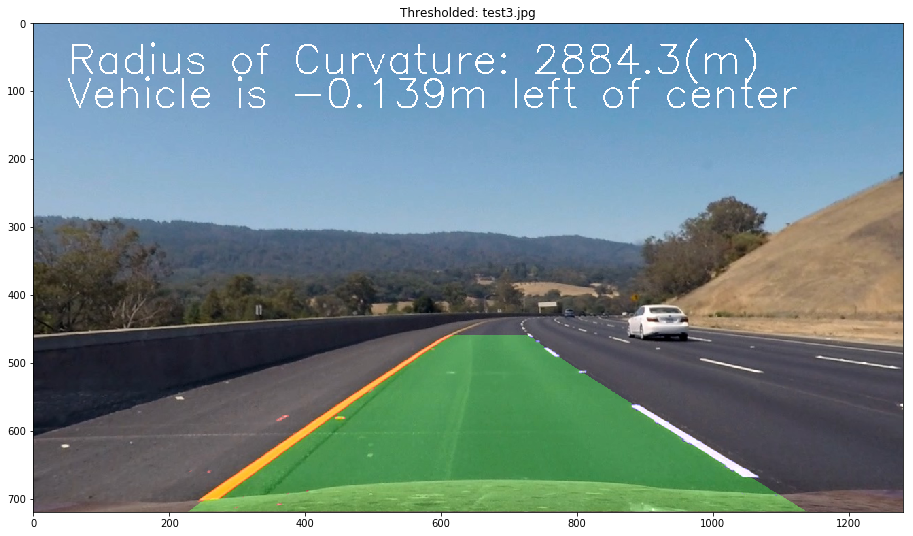

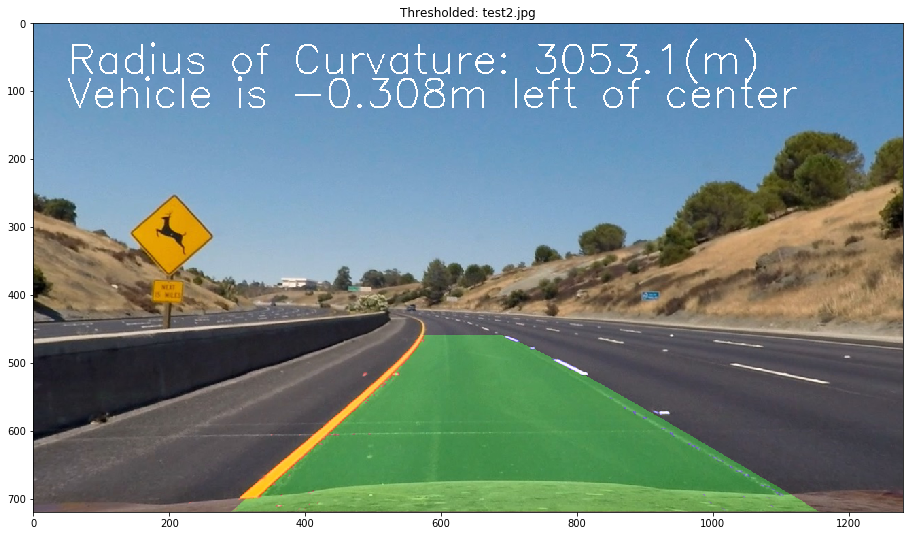

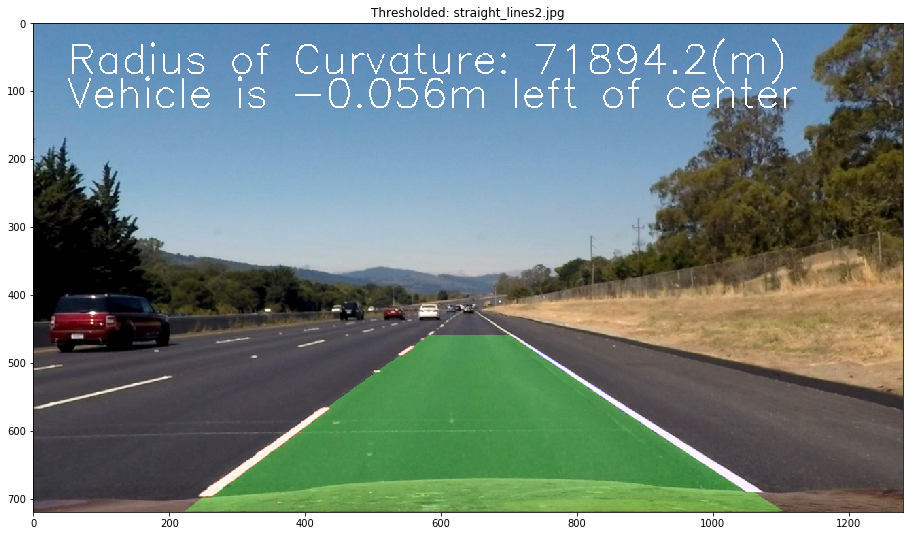

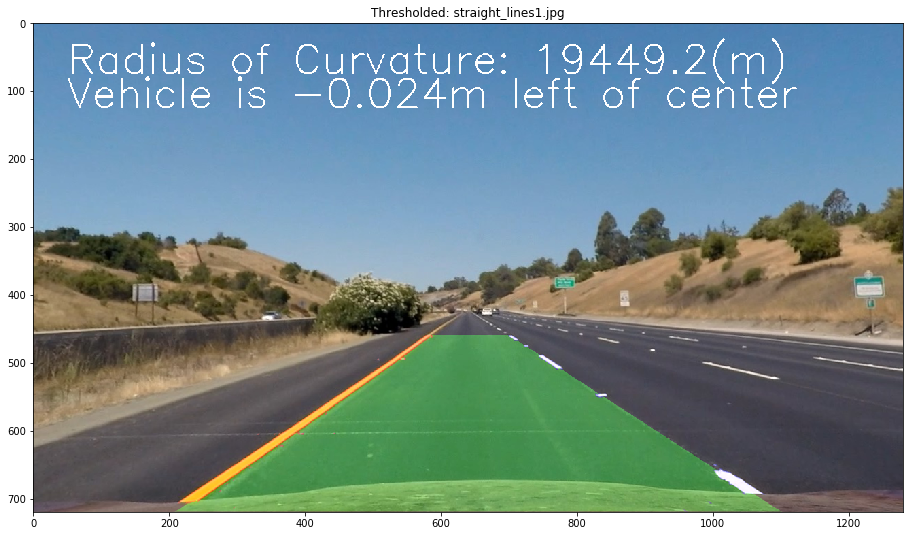

In [13]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    binary_image = create_binary_image(dst)
    img_warped = apply_perspective_transform(dst)
    binary_warped = apply_perspective_transform(binary_image)
    left_fit, right_fit,  left_fitx, right_fitx, out_img = draw_lane_area(img_warped, binary_warped)
    lane_region = apply_inverse_perspective_transform(out_img)

    curvature = calculate_curvature(left_fit, right_fit)
    vehicle_position = calculate_vehicle_position(left_fitx, right_fitx)
    cv2.putText(dst,"Radius of Curvature: %.1f(m)" % curvature, (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    cv2.putText(dst, "Vehicle is %.3fm left of center" % vehicle_position, (50,125), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    result = cv2.addWeighted(dst, 1, lane_region, 0.3, 0)


    plt.figure(figsize=(30,9))
    plt.title('Thresholded: ' + fname.split('/')[-1])
    plt.imshow(result)

    plt.savefig('output_images/' + fname.split('/')[-1], bbox_inches='tight', pad_inches=0)



In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [15]:
def process_image(image):
#     img = mpimg.imread(fname)
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    binary_image = create_binary_image(dst)
    img_warped = apply_perspective_transform(dst)
    binary_warped = apply_perspective_transform(binary_image)
    left_fit, right_fit,  left_fitx, right_fitx, out_img = draw_lane_area(img_warped, binary_warped)
    lane_region = apply_inverse_perspective_transform(out_img)

    curvature = calculate_curvature(left_fit, right_fit)
    vehicle_position = calculate_vehicle_position(left_fitx, right_fitx)
    cv2.putText(dst,"Radius of Curvature: %.1f(m)" % curvature, (50,75), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    cv2.putText(dst, "Vehicle is %.3fm left of center" % vehicle_position, (50,125), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 2)
    result = cv2.addWeighted(dst, 1, lane_region, 0.3, 0)
    
    return result

In [16]:
output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")

output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [01:24<00:00, 12.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 2min 31s, sys: 5.59 s, total: 2min 36s
Wall time: 1min 25s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))